In [238]:
import tensorflow as tf
from keras.layers import Activation, SeparableConv2D, BatchNormalization, MaxPooling2D, Rescaling, Conv2D, add, GlobalAveragePooling2D, Dropout, Dense, RandomFlip, RandomRotation, CenterCrop
from keras import Input, Model, Sequential
from keras.utils import plot_model, image_dataset_from_directory, split_dataset
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
from keras.metrics import Precision, Recall, AUC, Accuracy

In [239]:
# Image size (width, height, dimensionality = 3)
image_size = (224, 224)

# Total classes for classification in the dataset
num_classes = 17

# Batch size
batch_size = 32

# Dataset directory
path_to_dataset = "../dataset"

epochs = 30

In [240]:
data_augmentation = Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
    ]
)

In [241]:
def make_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Data augmentation
    x = data_augmentation(inputs)

    # Entry block
    x = Rescaling(1.0 / 255)(x)
    x = Conv2D(128, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = Activation("relu")(x)
        x = SeparableConv2D(size, 3, padding="same")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )

        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = SeparableConv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = GlobalAveragePooling2D()(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs)

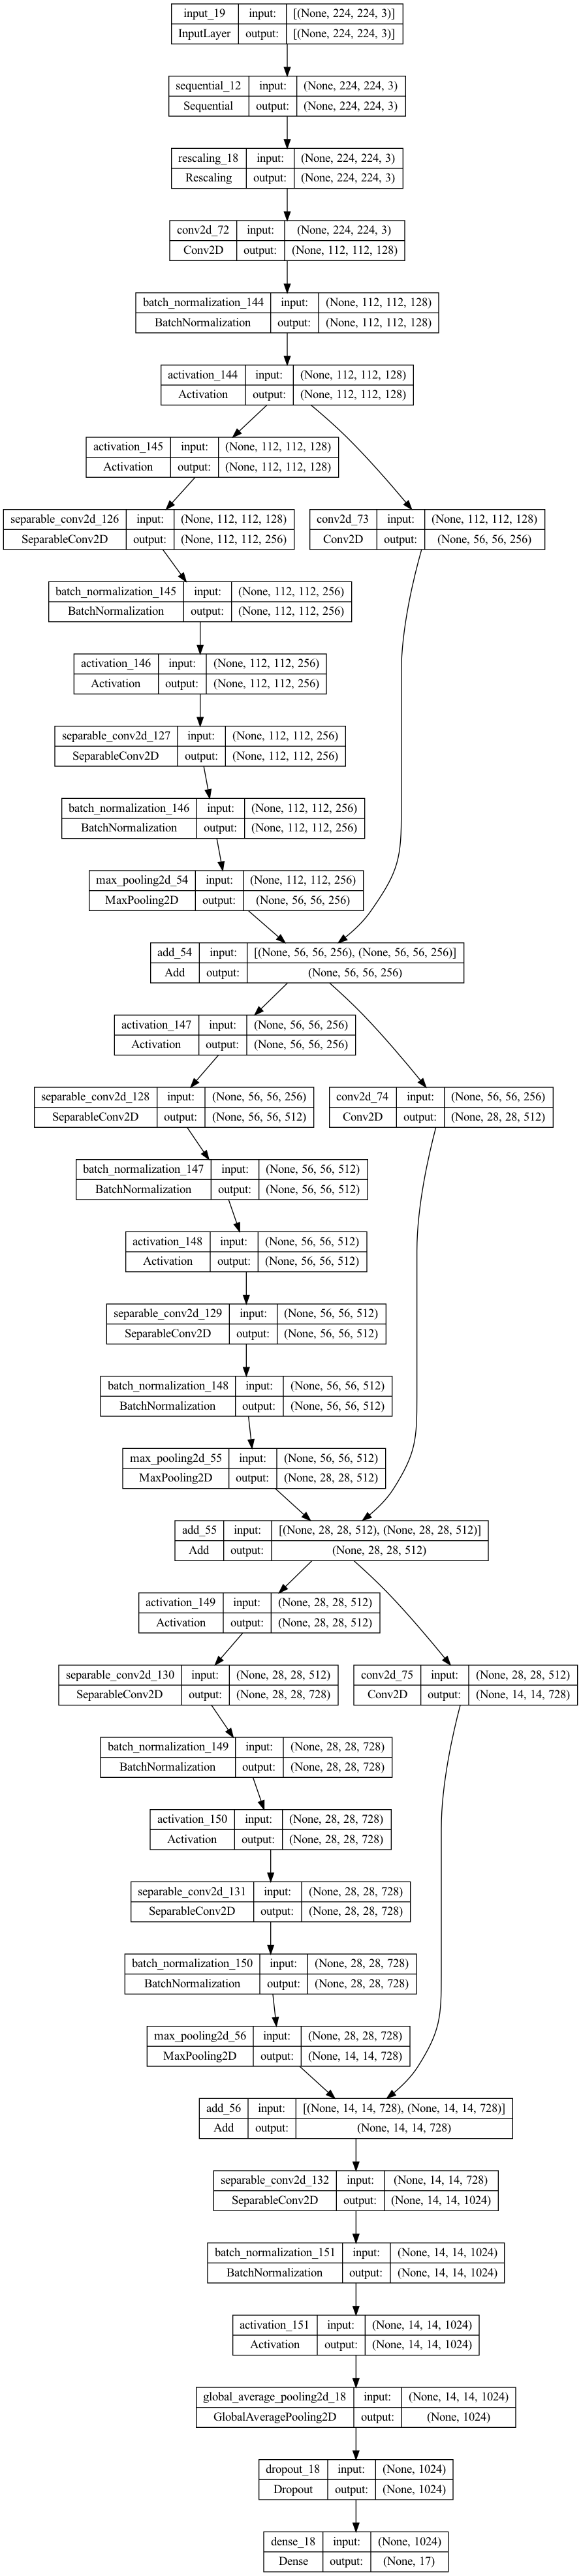

In [242]:
model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
plot_model(model, show_shapes=True)

In [256]:
model.count_params()

2747465

In [243]:
train_ds, val_ds = image_dataset_from_directory(
    path_to_dataset,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size= image_size,
    batch_size=batch_size,
)

Found 4415 files belonging to 17 classes.
Using 3532 files for training.
Using 883 files for validation.


In [244]:
train_ds.class_names

['Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1',
 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T1C+',
 'Glioma (Astrocitoma, Ganglioglioma, Glioblastoma, Oligodendroglioma, Ependimoma) T2',
 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1',
 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T1C+',
 'Meningioma (de Baixo Grau, Atípico, Anaplásico, Transicional) T2',
 'NORMAL T1',
 'NORMAL T2',
 'Neurocitoma (Central - Intraventricular, Extraventricular) T1',
 'Neurocitoma (Central - Intraventricular, Extraventricular) T1C+',
 'Neurocitoma (Central - Intraventricular, Extraventricular) T2',
 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1',
 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T1C+',
 'Outros Tipos de Lesões (Abscessos, Cistos, Encefalopatias Diversas) T2',
 'Schwannoma (Acustico, Vestibular - Trigeminal) T1',
 'Schwannoma (Ac

In [245]:
# Split the test dataset from the train dataset
train_ds, test_ds = split_dataset(
    train_ds, left_size=None, right_size=0.1
)

In [246]:
train_ds.element_spec[0].shape

TensorShape([None, 224, 224, 3])

In [247]:
# Save the best performing model at a particular epoch. Include the epoch in the name of the model
callbacks = [
    ModelCheckpoint(
        filepath="image_classification_from_scratch_model_saved_at_{epoch}_epoch.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
]

In [248]:
# Compile the model with Adam optimizer
model.compile(
    optimizer=RMSprop(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [249]:
# Fit the model on the train dataset and validate it on th validation dataset.
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/30
100/100 [==============================] - 413s 4s/step - loss: 2.2632 - accuracy: 0.2671 - val_loss: 2.9427 - val_accuracy: 0.0872
Epoch 2/30
100/100 [==============================] - 392s 4s/step - loss: 1.5724 - accuracy: 0.4671 - val_loss: 3.8289 - val_accuracy: 0.0872
Epoch 3/30
100/100 [==============================] - 389s 4s/step - loss: 1.2581 - accuracy: 0.5700 - val_loss: 5.9822 - val_accuracy: 0.0883
Epoch 4/30
100/100 [==============================] - 424s 4s/step - loss: 1.0717 - accuracy: 0.6282 - val_loss: 7.4403 - val_accuracy: 0.0849
Epoch 5/30
100/100 [==============================] - 414s 4s/step - loss: 0.9454 - accuracy: 0.6769 - val_loss: 6.4165 - val_accuracy: 0.0940
Epoch 6/30
100/100 [==============================] - 409s 4s/step - loss: 0.8484 - accuracy: 0.7062 - val_loss: 2.6875 - val_accuracy: 0.2741
Epoch 7/30
100/100 [==============================] - 415s 4s/step - loss: 0.7348 - accuracy: 0.7474 - val_loss: 1.6665 - val_accuracy: 0.5696

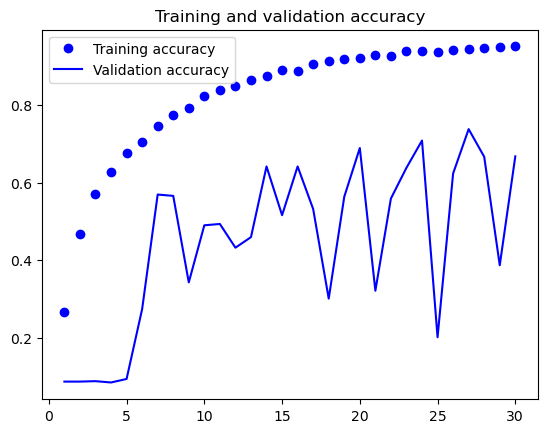

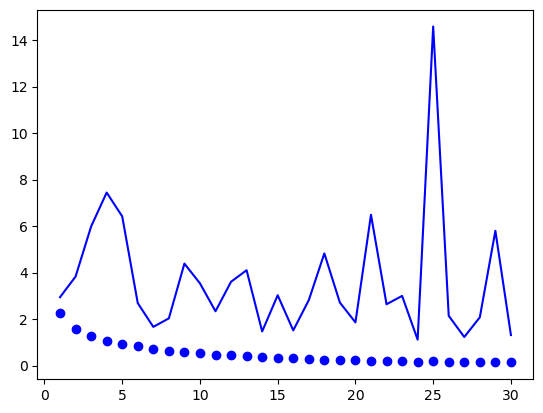

In [255]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")

In [251]:
test_model = load_model("image_classification_from_scratch_model_saved_at_24_epoch.keras")
test_loss, test_acc = test_model.evaluate(test_ds)

12/12 [==============================] - 12s 927ms/step - loss: 1.2135 - accuracy: 0.6941


In [253]:
print(f"Test accuracy: {test_acc:.3f} and Test loss: {test_loss:.3f}")

Test accuracy: 0.694 and Test loss: 1.214
